<a href="https://colab.research.google.com/github/sd411/Computer_Vision/blob/main/HumanActivityRecog/har.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.Loading the dataset from google drive**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from sklearn.datasets import load_files #importing libraries required for loading video files

In [ ]:
%cd /content/drive/My Drive/Hum_act_rec

/content/drive/My Drive/Hum_act_rec


In [ ]:
data = load_files(os.getcwd() + r'/dataset_humact', shuffle=False)
#load_files function returns the files holding our dataset and the target labels
#os.getcwd() returns the current working directory
#Thus sklearn's load_files function makes it easy for us to import datasets and generate a label based array based on the dataset 

In [ ]:
dataset = data['filenames'] #this returns the files into our dataset object

In [ ]:
labels = data['target']#this returns the labels of each file according to their respective classes

**2. Splitting our dataset into training and test set**

In [ ]:
# Now we will split our loaded dataset and labels into training , validation and test sets
from sklearn.model_selection import train_test_split

In [ ]:
train_set, test_set, train_labels, test_labels = train_test_split(dataset,labels, test_size=1/5)
#Now we have made training set =  80% and test set =  20% of the complete dataset

In [ ]:
valid_set = train_set[450:]
valid_labels = train_labels[450:]

train_set = train_set[:70] #using small training set due to limited ram available in google collab
train_labels = train_labels[:70] #small label set due to limited ram availabilty


# the above code will generate a validation set which will include approx 80 videos which will be used a validation set for improving our model
# the remaining(70 because of ram usage) will form the training set


test_set = test_set[:30]#reducing test_set to reduce ram usage
test_labels=test_labels[:30]#reducing test_set to reduce ram usage

#Thus to reduce ram usage in google collab we have now 70 videos in training set,28 videos in validation set and 30 videos in test set

**3.Visualizing a frame from a video from our dataset**

In [ ]:
!pip install videoutils
import numpy as np
import matplotlib.pyplot as plt
from videoutils.io import read_video
%matplotlib inline
#using read_video function to read videos from dataset

In [ ]:
sample = '/content/drive/My Drive/Hum_act_rec/dataset_humact/boxing/person01_boxing_d1_uncomp.avi'
#specifying the location of our video file


In [ ]:
x = read_video(sample) #returns an array of frames

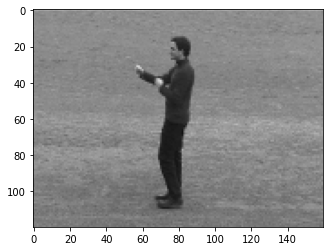

In [ ]:
plt.imshow(x[0])#shows us the first frame of the selected video

**4.Preprocessing the dataset**

In [ ]:
#First we will convert the videos into grayscale so as to reduce our computational expense and complexity of our model.
#Then we'll proceed with selecting same frames from all the videos to avoid error in our model
#Then we'll normalize the pixel values in the frames (images) which is done to imporve our model
#We will resize the frames of our videos to make sure all frames of all videos are of same spatial dimensions
#we'll make use of utils.py file which contains a class Videos which will help us to do all the preprocessing tasks
#Then finally we will one hot encode the classes of our model this helps to improve the accuracy of our model and prevents the model from prioritizing certain classes

In [ ]:
%cd /content/drive/My Drive/Hum_act_rec/utilities


/content/drive/My Drive/Hum_act_rec/utilities


In [ ]:
!pip install sk-video

In [ ]:
import numpy as np
from keras.utils import to_categorical
from utils import Videos

In [ ]:
preproc = Videos(target_size=(128, 128),to_gray=True, max_frames=200, extract_frames='middle', normalize_pixels=(0, 1))
#it converts the frames(of videos) into 128*128 pixels format
#limits the max frames taken per video to 200(from middle of the video)
#converts the image into grayscale
#normalizes the pixel values to between 0 and 1

In [ ]:
X_train = preproc.read_videos(train_set) #preprocessing training set videos
y_train = to_categorical(train_labels, num_classes=6) #one hot encoding training labels

100%|██████████| 70/70 [01:00<00:00,  1.15it/s]


In [ ]:
X_valid = preproc.read_videos(valid_set) #preprocessing the validation set
y_valid = to_categorical(valid_labels, num_classes=6)#one hot encoding the validation labels


100%|██████████| 28/28 [00:32<00:00,  1.15s/it]


In [ ]:
X_test = preproc.read_videos(test_set)#preprocessing the test set
y_test = to_categorical(test_labels, num_classes=6)#one hot encoding the test labels

100%|██████████| 30/30 [00:34<00:00,  1.16s/it]


**5.Building a Simple Model**

In [ ]:
# We will build a simple CNN model to classify our videos and then show its accuracy
# Our model will consist of 2 Convolution layers, 2 Max Pooling layers, 1 global average pooling layer and 2 Dense fully connected layers 
# The convolutional layer extracts the features from the images(frames) and maintains the spatial realations with the nearby pixels.This is done through applying certain filters to the images.
# The MaxPooling layer takes the max value(pixel value) of the specified window so as to reduce the spatial dimensions of our input
# The global average pooling layer converts the output of maxpooling layer into a 1-d vector which will be further used as input to dense layer

In [ ]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.layers.core import Dense

cnn = Sequential() #we use the sequential class to initiate our CNN
cnn.add(Conv3D(filters=32, kernel_size=(8, 3, 3), strides=(6, 1, 1),activation='relu', input_shape=X_train.shape[1:]))
#we add a Convolutional layer that has 32 filters/feature maps which are applied to the images ,each window that gets convolved along the image is of kernel size and moves with the specified stride
#relu activation function is used to remove any linearities in the image
cnn.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2)))# we add max pooling layer and specify its size and stride by which its gets shifted along the image

#We add a second set of layers in a similar pattern but we dont need to specify input size in the convolutional layer because of our keras library's functionality
cnn.add(Conv3D(filters=64, kernel_size=(4, 3, 3), strides=(4, 1, 1),activation='relu'))
cnn.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2)))

#Now we'll add the global average pooling layer which'll convert the output of recent maxpooling layer into a 1-d vector
cnn.add(GlobalAveragePooling3D())

#Now we will add 2 fully connected dense layers(neural network) out of which one will be hidden layer and one will be output layer
cnn.add(Dense(16, activation='relu'))# relu activation function is used in the hidden layer 

#Output layer
cnn.add(Dense(6, activation='softmax'))#softmax activation function is used when there are more than two classes to predict in our model

#The output from this layer will be a vector in the one hot encoded form which will represent the activity of the video as predicted by our model



In [ ]:
#Now we will compile our model
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#As we have more than 2 classes to predict we'll use categorical_crossentropy as the loss function ,the optimizer will optimize the weights of the model based on gradient descent method
#And we supply the metrics as accuracy of our model

In [ ]:
#Now we will train our model using batch sizes of 32 images and train it 10 times on the trainig set
cnn_comp = cnn.fit(X_train, y_train, batch_size=32, epochs=20,validation_data=(X_valid, y_valid), verbose=2)

Epoch 1/20
3/3 - 2s - loss: 1.7931 - accuracy: 0.1714 - val_loss: 1.7772 - val_accuracy: 0.2500
Epoch 2/20
3/3 - 2s - loss: 1.7537 - accuracy: 0.2714 - val_loss: 1.7762 - val_accuracy: 0.2500
Epoch 3/20
3/3 - 2s - loss: 1.7568 - accuracy: 0.2714 - val_loss: 1.7742 - val_accuracy: 0.2500
Epoch 4/20
3/3 - 2s - loss: 1.7567 - accuracy: 0.2714 - val_loss: 1.7768 - val_accuracy: 0.2500
Epoch 5/20
3/3 - 1s - loss: 1.7523 - accuracy: 0.2714 - val_loss: 1.7782 - val_accuracy: 0.2500
Epoch 6/20
3/3 - 2s - loss: 1.7499 - accuracy: 0.2714 - val_loss: 1.7825 - val_accuracy: 0.2500
Epoch 7/20
3/3 - 1s - loss: 1.7500 - accuracy: 0.2714 - val_loss: 1.7852 - val_accuracy: 0.2500
Epoch 8/20
3/3 - 1s - loss: 1.7487 - accuracy: 0.2714 - val_loss: 1.7774 - val_accuracy: 0.2500
Epoch 9/20
3/3 - 1s - loss: 1.7456 - accuracy: 0.2714 - val_loss: 1.7714 - val_accuracy: 0.2500
Epoch 10/20
3/3 - 1s - loss: 1.7487 - accuracy: 0.2714 - val_loss: 1.7657 - val_accuracy: 0.2500
Epoch 11/20
3/3 - 2s - loss: 1.7459 - a

**6.Evaluating our model**

In [ ]:
(loss, accuracy) = cnn.evaluate(X_test, y_test, batch_size=16, verbose=0)
print('Accuracy on test data: {:.4f}%'.format(accuracy * 100))

Accuracy on test data: 20.0000%


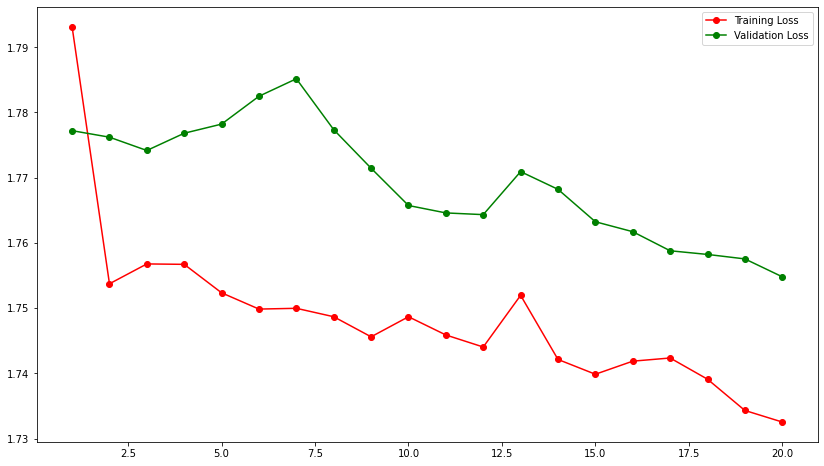

In [ ]:
#We can also visualize the loss on our training set and validation set
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))

loss = cnn_comp.history['loss'] #training data loss                        
val_loss = cnn_comp.history['val_loss']#validation data loss                   
epochs = range(1, 21)#selecting epochs 1 to 20

plt.plot(epochs, loss, 'ro-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label = 'Validation Loss')
plt.legend()

In [ ]:
# As one can infer from the above visualiztion our model works fine till 2 epochs (approx) after that it starts overfitting the training set
# (it starts remembering the pattern in training set) and as result the training loss keeps decreasing while th validation loss increases .
# Increasing the training data size(which we reduced due to ram usage complications) , reducing batch size , Using hyperparameter tuning to
# find out the optimal parameters for our model,Dropout regularization ,K-Folds Cross validation technique,increasing the layers of our network
# are some of the methods that can be employed to tackle the above problem.